# Sessie 3 - Stelsels van lineaire vergelijkingen

Voer de onderstaande code uit.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## Protein folding en PSICOV

De Protein Data Bank ([PDB](http://www.rcsb.org/pdb/home/home.do)) is een database die allerlei informatie bevat over proteinen. Deze database bevat o.a. de 3D structuur van proteinen. Om deze structuur te bepalen (zie [protein folding](https://en.wikipedia.org/wiki/Protein_folding)), hebben we geautomatiseerde methodes nodig.

We kunnen bijvoorbeeld kijken naar hoe proteinen evolueren. Het is geweten dat de 3D proteinstructuur bij mutatie meestal wordt behouden, en dus de amino-zuren (i.e., de deeltjes die een protein opmaken) gebonden moeten blijven. Dit wil zeggen dat de aminozuren die in contact zijn met elkaar moeten co-muteren om de chemische bindingen te behouden. Met andere woorden, als we naar <i>verschillende</i> sequenties van <i>hetzelfde</i> protein kijken, kunnen we relaties vinden tussen aminozuren in termen van co-mutaties.

Een statistische methode dat gebruik maakt van dit idee, heet [PSICOV](http://www.ncbi.nlm.nih.gov/pubmed/22101153) en werkt als volgt:
1. Stel een covariantie matrix van amino-paren op uit protein data.
2. Inverteer deze matrix om correlaties te bekomen tussen amino-paren
3. Bereken voor ieder paar wat de waarschijnlijkheid is dat deze zuren in contact zijn.

De code voor stap 1 en 3 is gegeven, maar het cruciale gedeelte van deze methode is stap 2, namelijk het inverteren van de covariantie matrix, daar we tot nu toe niet echt stabiele of efficiente methodes hebben gezien. Stabiliteit is nodig, aangezien we zullen werken met een $420 \times 420$ matrix voor een kleine sequentie van aminozuren (in de praktijk is dit gemiddeld een $3150 \times 3150$ matrix).

<b>ANSWER:</b>

* Constructie van het algoritme:
$$
a_{ij} = \sum\limits^{min(i,j)}_{m=1} l_{im}l_{mj}
\Rightarrow \begin{cases}
                a_{ii} = \sum\limits^{i-1}_{m = 1} l^2_{ij} + l^2_{ii}\\
                a_{ij} = \sum\limits^{j-1}_{m=1} l_{im}l_{jm} + l_{ij}l_{jj} \text{ als }i > j
            \end{cases} 
\Rightarrow \begin{cases}
                l_{ii} = \sqrt{a_{ii} - \sum\limits^{i-1}_{m = 1} l^2_{ij}} \\ 
                l_{ij} = \frac{1}{l_{jj}}(a_{ij} - \sum\limits^{j-1}_{m=1} l_{im}l_{jm}) \text{ als }i > j
            \end{cases}
$$

Extra uitleg:

\begin{equation*}
A = 
\begin{pmatrix}
   a_{11} & a_{21} & a_{31}\\
   a_{21} & a_{22} & a_{32}\\
   a_{31} & a_{32} & a_{33}\\
\end{pmatrix}
= \\
\begin{pmatrix}
   l_{11} & 0 & 0 \\
   l_{21} & l_{22} & 0 \\
   l_{31} & l_{32} & l_{33}\\
\end{pmatrix}
\begin{pmatrix}
   l_{11} & l_{21} & l_{31} \\
   0 & l_{22} & l_{32} \\
   0 & 0 & l_{33}
\end{pmatrix} \equiv LL^T\\
= \\
\begin{pmatrix}
   l_{11}^2     & l_{21}l_{11} & l_{31}l_{11} \\
   l_{21}l_{11} & l_{21}^2 + l_{22}^2& l_{31}l_{21}+l_{32}l_{22} \\
   l_{31}l_{11} & l_{31}l_{21}+l_{32}l_{22} & l_{31}^2 + l_{32}^2+l_{33}^2
\end{pmatrix}
\end{equation*}

In dit 3x3 voorbeeld, lossen we het volgende systeem:

We kunnen zien dat er een patroon is om de diagonaal elementen van $L$ te berekenen:

$$l_{11} = \sqrt{a_{11}}$$
$$l_{22} = \sqrt{a_{22} - l_{21}^2}$$
$$l_{33} = \sqrt{a_{33} - (l_{31}^2 + l_{32}^2)}$$

of in het algemeen:

$$l_{ii} = \sqrt{a_{ii} - \sum_{m=1}^{i-1} l_{im}^2}$$

Voor de elementen onder de diagonaal ($l_{ij}$, waar $i > j$) is er ook een onderliggend patroon:

$$l_{21} = \frac{1}{l_{11}} a_{21}$$
$$l_{31} = \frac{1}{l_{11}} a_{31}$$
$$l_{32} = \frac{1}{l_{22}} (a_{32} - l_{31}l_{21})$$

of in het algemeen:
$$l_{ij} = \frac{1}{l_{jj}} \left ( a_{ij} - \sum_{m=1}^{j-1} l_{im}l_{jm} \right )$$

In [2]:
def cholesky(A):
    """
    Gegeven een matrix A, pas de Cholesky decompositie (A = LL') toe en geef de matrix L terug. 
    """
    n = len(A)
    L = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i):
            # in numpy: L[i, :j] => alle elementen uit rij i van kolom 0 tot en met kolom j-1 (dus kolom j niet)
            L[i, j] = (1 / L[j, j]) * (A[i, j] - np.dot(L[i, :j], L[j, :j]))
        L[i, i] = np.sqrt(A[i, i] - np.dot(L[i, :i], L[i, :i]))
    return L

In [3]:
# TEST ###
L = np.asmatrix([[1, 0, 0],[2, 3, 0],[4, 5, 6]])
A = L*L.transpose()

L_new = cholesky(A)
print("Error: ", str(np.linalg.norm(L_new - L)))

Error:  0.0


## 2. Stabiliteit

Een LU-decompositie is numeriek niet sterk stabiel.
Neem $F(L, U) = A + \Delta A$.<br>
Dan wordt de onvermijdelijke fout gegeven door:
$$\delta F \le \frac{||L|| \cdot ||U||}{||A||} \cdot C \cdot \epsilon$$
met $\epsilon$ de machineprecisie en $C$ een constante.<br>
Aangezien $||L||$ en $||U||$ arbitrair groot kunnen worden, is dit algoritme niet sterk stabiel.

Leg uit waarom een Cholesky decompositie <i>wel</i> sterk stabiel is.

(Opmerking: $||M|| = \sqrt{\sum\limits_{i,j} M_{ij}^2}$ voor een matrix $M$.)<br>
(Hint: $||MM'|| = ||M||^2$)

<b>ANSWER:</b>

Aangezien $U = L'$, krijgen we
$$\delta F \le \frac{||L|| \cdot ||L'||}{||A||} \cdot C \cdot \epsilon = \frac{||L||^2}{||A||} \cdot C \cdot \epsilon =  \frac{||LL'||}{||A||} \cdot C \cdot \epsilon = \frac{||A||}{||A||} \cdot C \cdot \epsilon = C \cdot \epsilon$$<br>
(Opmerking: Bij een LU-decompositie, heb je in het algemeen $\frac{||L||\cdot||U||}{||A||} \ge \frac{||LU||}{||A||}$, waardoor je de linker term dus niet op dezelfde manier kunt begrenzen.)

## 3. Inverse covariantie matrix

Aangezien iedere covariantie matrix een symmetrische positief semi-definiete matrix is, kunnen we de Cholesky decompositie van een covariantie matrix op een stabiele manier berekenen.

We kunnen dit toepassen op de covariantie matrix van het protein <i>1ag6A</i> om zo de PSICOV methode te vervolledigen.

De volgende files worden in de test-code gebruikt en mogen niet aangepast worden:
* $\texttt{1ag6A-20.csv}$ - Covariantie matrix
* $\texttt{1ag6A.CB}$ - Werkelijke contacten
* $\texttt{psicov.py}$ - Code om de covariantie matrix in te lezen en contacten te voorspellen (stap 1 en 3 van PSICOV)

Kan je gebruikmakend van jouw geimplementeerde Cholesky decompositie de inverse berekenen en de PSICOV methode vervolledigen?

<b>ANSWER:</b>

Los de volgende stelsels op (zie LU decompositie):
$$\begin{cases}
LY = I \quad\ \ \text{ [gebruik voorwaartse substitutie]}\\
L'X = Y \quad \text{ [gebruik achterwaartse substutie]}
\end{cases}$$
Dit geeft de inverse van de matrix $A = LL'$, want
$$\begin{cases}
LY = I \Leftrightarrow Y = L^{-1}\\
L'X = Y = L^{-1} \Leftrightarrow X = (L')^{-1}L^{-1} = (LL')^{-1} = A^{-1}
\end{cases}$$

In [11]:
import scipy.linalg

# Functies om Ax = b op te lossen, gebruikmakend van voorwaartse en
# achterwaartste substitutie met parameters A en b.
forward = lambda A, b: scipy.linalg.solve_triangular(A, b, lower=True)
backward = lambda A, b: scipy.linalg.solve_triangular(A, b, lower=False)
    
def inv_cov(M):
    """
    Inverteer een covariantie matrix M.
    """
    L = cholesky(M)
    Y = forward(L, np.identity(len(L)))
    X = backward(L.transpose(), Y)
    return(X)

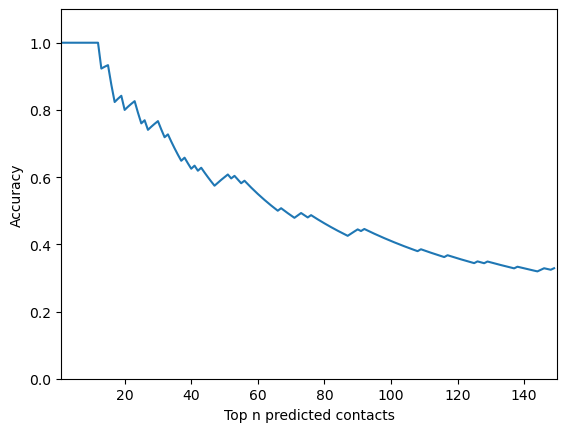

In [12]:
%run psicov.py

### TEST ###

#Retrieve the covariance matrix of 1ag6A and compute the inverse
M = retrieve_covariance_matrix('1ag6A-20.csv')
M_inv = inv_cov(M)

#Predict the amino-amino contacts and compare it with the actual contacts
pred_contacts = retrieve_predicted_contacts(M_inv)
true_contacts = retrieve_true_contacts('1ag6A.CB', 8)
n = range(1, 150)
accuracies = [fraction_of_correct_predictions(pred_contacts[:i], true_contacts) for i in n]

### PLOT ###
plt.plot(n, accuracies)
plt.xlabel('Top n predicted contacts')
plt.ylabel('Accuracy')
plt.xlim(1,150)
plt.ylim(0,1.1)
plt.show()